# Niche definition using spatial neighbors  
### Spatial pancreas  
Subset of a non-diabetic slide (fov == 12) 

### Pre-requisites

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np

import scanpy as sc
import squidpy as sq

import matplotlib.pyplot as plt

#sc.settings.set_figure_params(dpi=80, facecolor="white")

### Load data

In [6]:
adata = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')
adata

/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [ ]:
adata = adata_s1[np.isin(adata_s1.obs['fov'],['12'])].copy()
adata

In [7]:
adata.obs['cell_type_coarse'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

In [8]:
adata.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

### Data Exploration

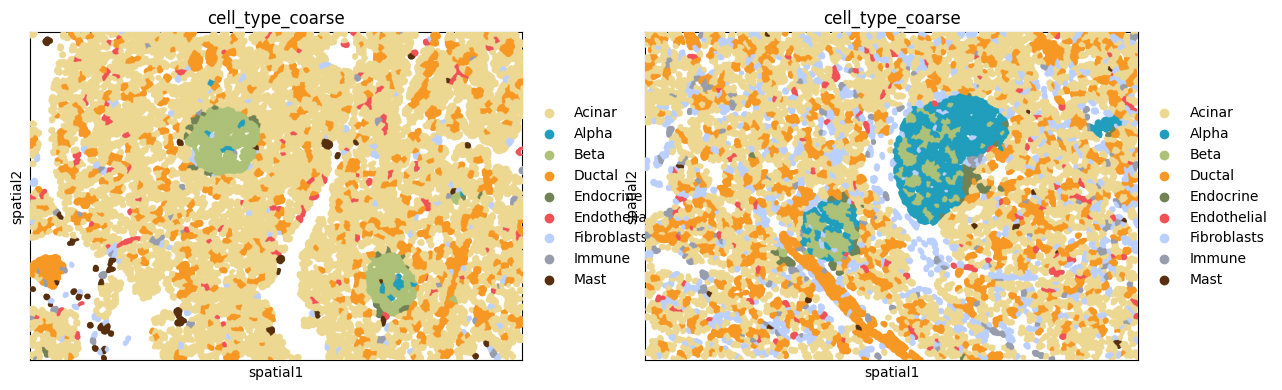

In [9]:
sq.pl.spatial_segment(adata,color='cell_type_coarse',ncols=2,library_id=['10','12'],
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [10]:
from matplotlib.pyplot import rc_context

In [11]:
HORMONES = ['INS','GCG','SST']
#adata.uns['cell_type_coarse_colors'] = ['#00bbf9', '#a7c957', '#F4BA41', '#e63946', '#6c757d', '#ffcdb2','#fb8500']

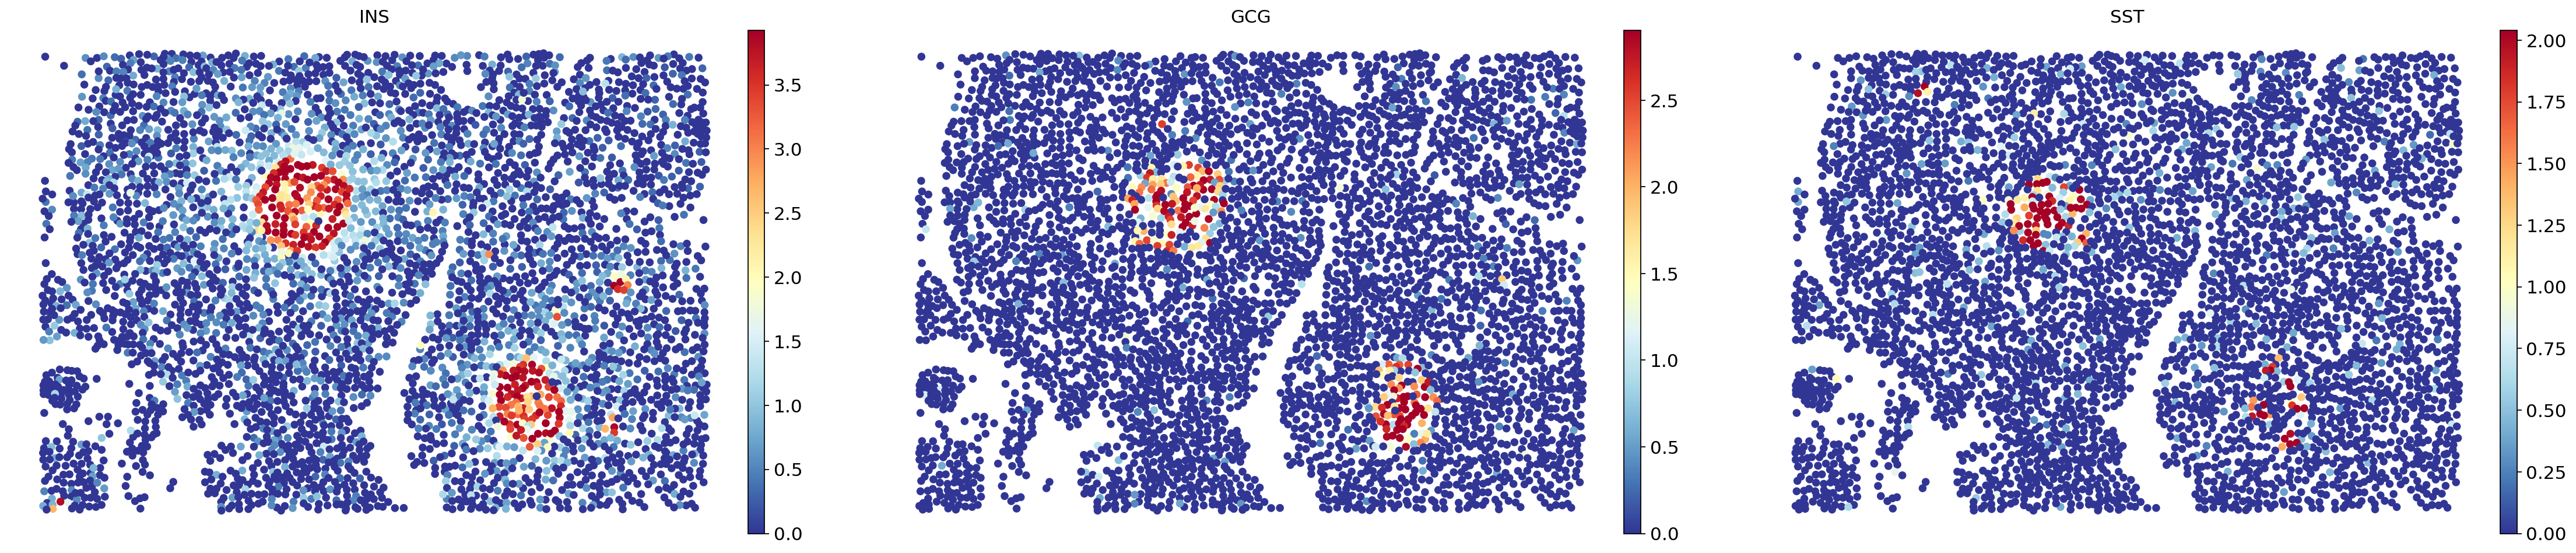

In [12]:
# Check expression of known markers to get intuition of the dataset
with rc_context({'figure.figsize': (10.5,7)}):
    sc.pl.embedding(
        adata,
        basis='spatial',
        color=HORMONES,
        vmin=0,
        vmax='p99',  
        sort_order=False,  
        frameon=False,
        cmap='RdYlBu_r', 
        size=150,ncols=3
    )

### Niche definition in terms of nearest neighbors

In [10]:
adata.X.max()

4.715945

In [11]:
adata.layers['counts'].max()

285

In [14]:
# calculating node degree for several distances 
for ng in [5,15,30,50,100,200]:
    connectivities, _ = sq.gr.spatial_neighbors(
        adata, n_neighs=ng, coord_type='generic', copy=True
    )
    print(np.mean(np.sum(connectivities, axis=0)))

5.0
15.0
30.0
50.0
100.0
200.0


In [68]:
sq.gr.spatial_neighbors(
    adata,
    n_neighs=50,
    library_key='fov', # to get the spatial graphs per slide (ie per fov)
    coord_type="generic",
    delaunay=False,
    
)

In [69]:
adata.obsp["spatial_connectivities"].shape

(108711, 108711)

/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]


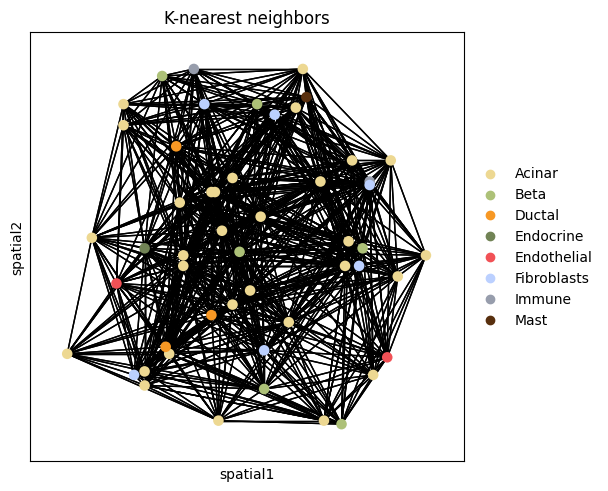

In [62]:
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata[idx,420],
    library_id = '12',
    color="cell_type_coarse",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors"
)

In [90]:
import anndata as ad

In [222]:
fov = adata[np.isin(adata.obs['fov'],['12'])].copy()
cell_type_key = 'cell_type_coarse'

niche_data = ad.AnnData(X = np.zeros((len(fov.obs_names),len(fov.obs[cell_type_key].unique()))),
                       obs = pd.DataFrame(index=fov.obs_names),
                       var = pd.DataFrame(index=fov.obs[cell_type_key].unique()))

niche_data.obs['obs_names'] = fov.obs_names
niche_data.var['var_names'] = fov.obs[cell_type_key].unique()

for c in range(len(fov.obs_names)):
    _, idx = fov.obsp["spatial_connectivities"][c, :].nonzero()
    idx = np.append(idx, c)
    cts = fov[idx,].obs[cell_type_key]
    
    for i in cts.unique():
        var_index = niche_data.var_names.get_loc(i)
        niche_data.X[c,var_index] = cts.value_counts()[i]

In [223]:
niche_data

AnnData object with n_obs × n_vars = 5208 × 9
    obs: 'obs_names'
    var: 'var_names'

In [224]:
niche_data.obs['cell_type'] = fov.obs['cell_type_coarse']

niche_data.uns['cell_type_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


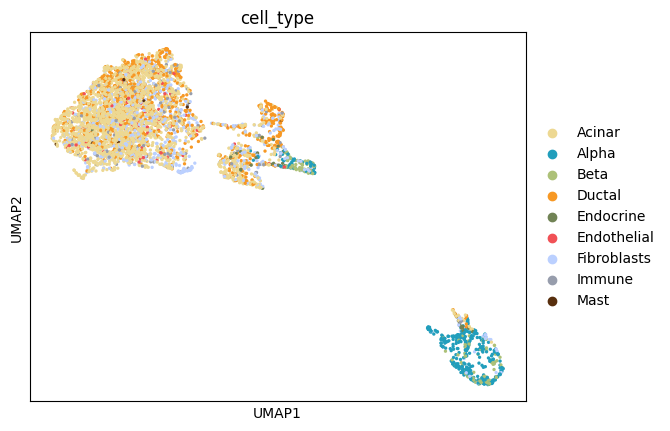

In [225]:
sc.pp.pca(niche_data)
sc.pp.neighbors(niche_data)
sc.tl.umap(niche_data)
sc.pl.umap(niche_data, color='cell_type')

In [226]:
res = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for r in range(len(res)):
    sc.tl.leiden(niche_data, resolution=res[r], key_added='res_'+str(res[r])) #, adjacency=fov.obsp["spatial_connectivities"])

In [227]:
niche_data

AnnData object with n_obs × n_vars = 5208 × 9
    obs: 'obs_names', 'cell_type', 'res_0', 'res_0.1', 'res_0.2', 'res_0.3', 'res_0.4', 'res_0.5', 'res_0.6', 'res_0.7', 'res_0.8', 'res_0.9', 'res_1.0'
    var: 'var_names'
    uns: 'cell_type_colors', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


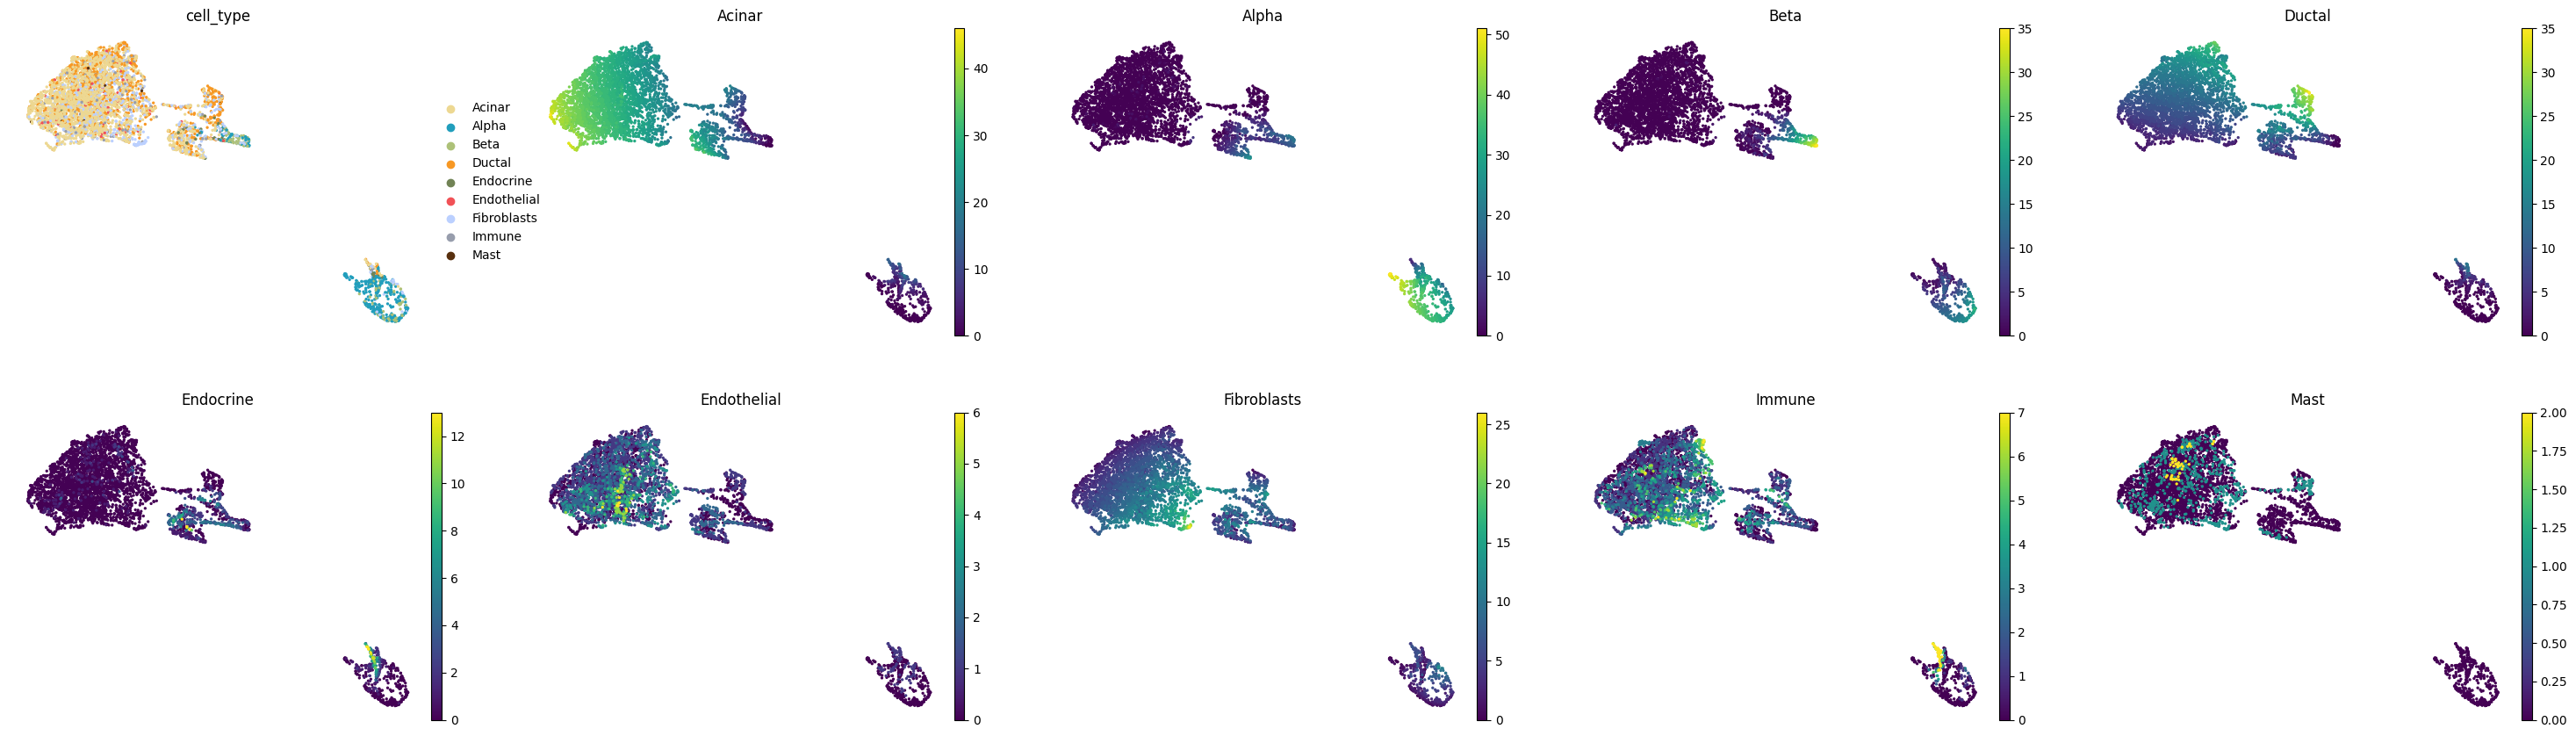

In [229]:
sc.pl.umap(niche_data, color=['cell_type','Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast' ],ncols=5,frameon=False)

/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  col

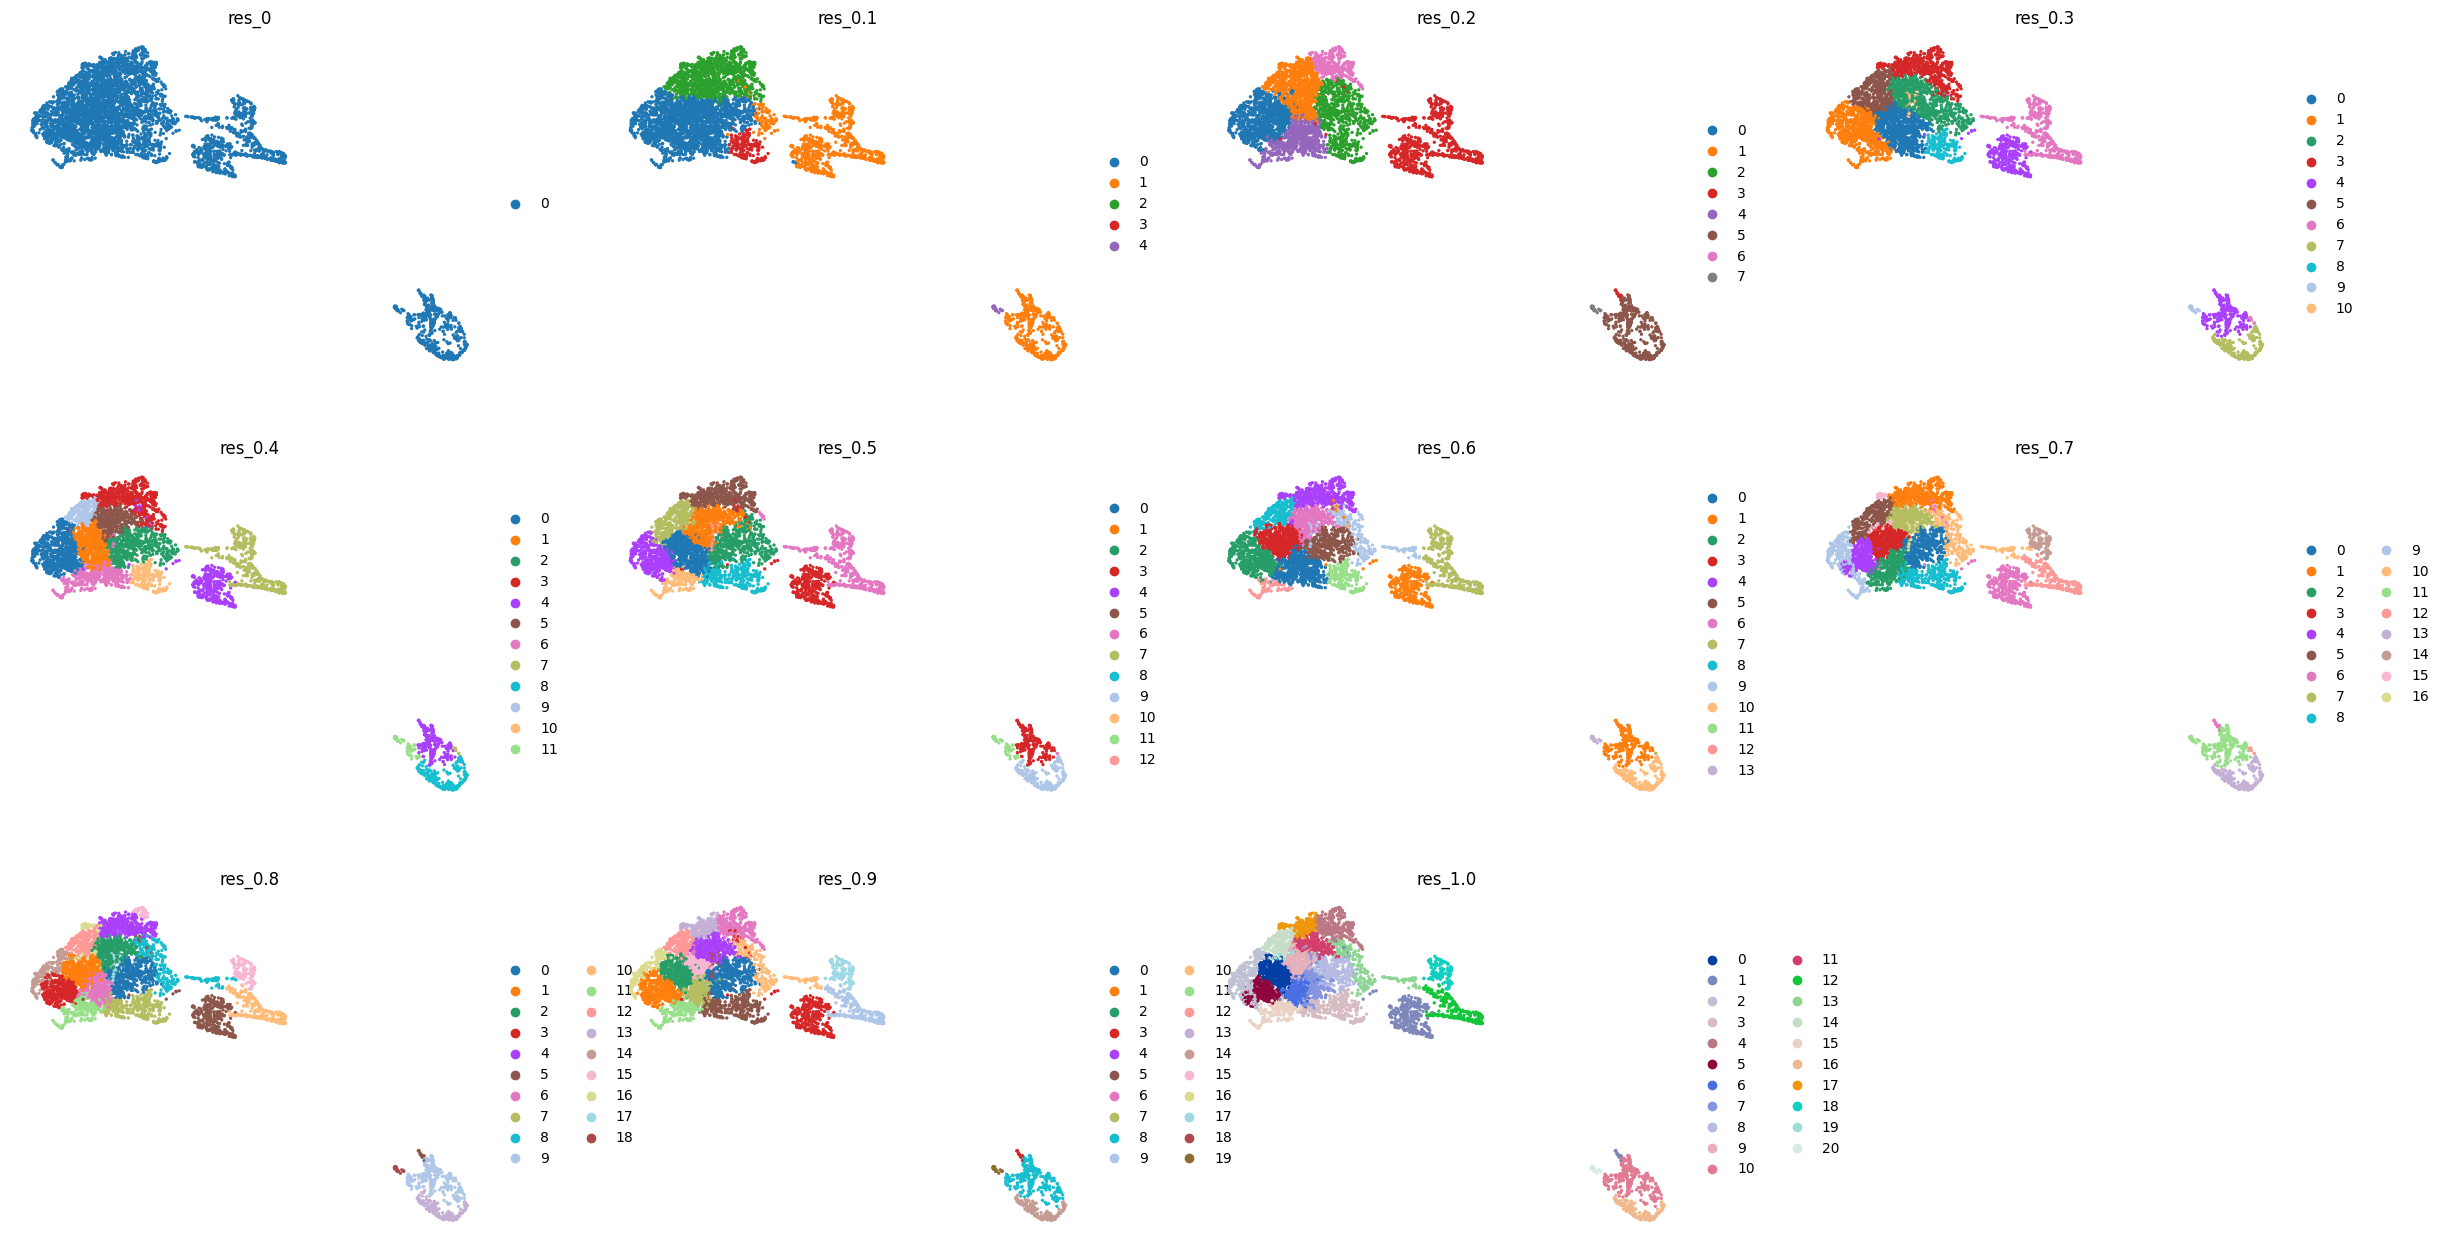

In [230]:
sc.pl.umap(niche_data, color=['res_0','res_0.1','res_0.2','res_0.3','res_0.4','res_0.5','res_0.6','res_0.7','res_0.8','res_0.9','res_1.0'],
           ncols=4,frameon=False)

In [231]:
sc.tl.leiden(niche_data, restrict_to=('res_0.1',['1']),resolution=0.3, key_added='res_0.1_'+str(0.3))

/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


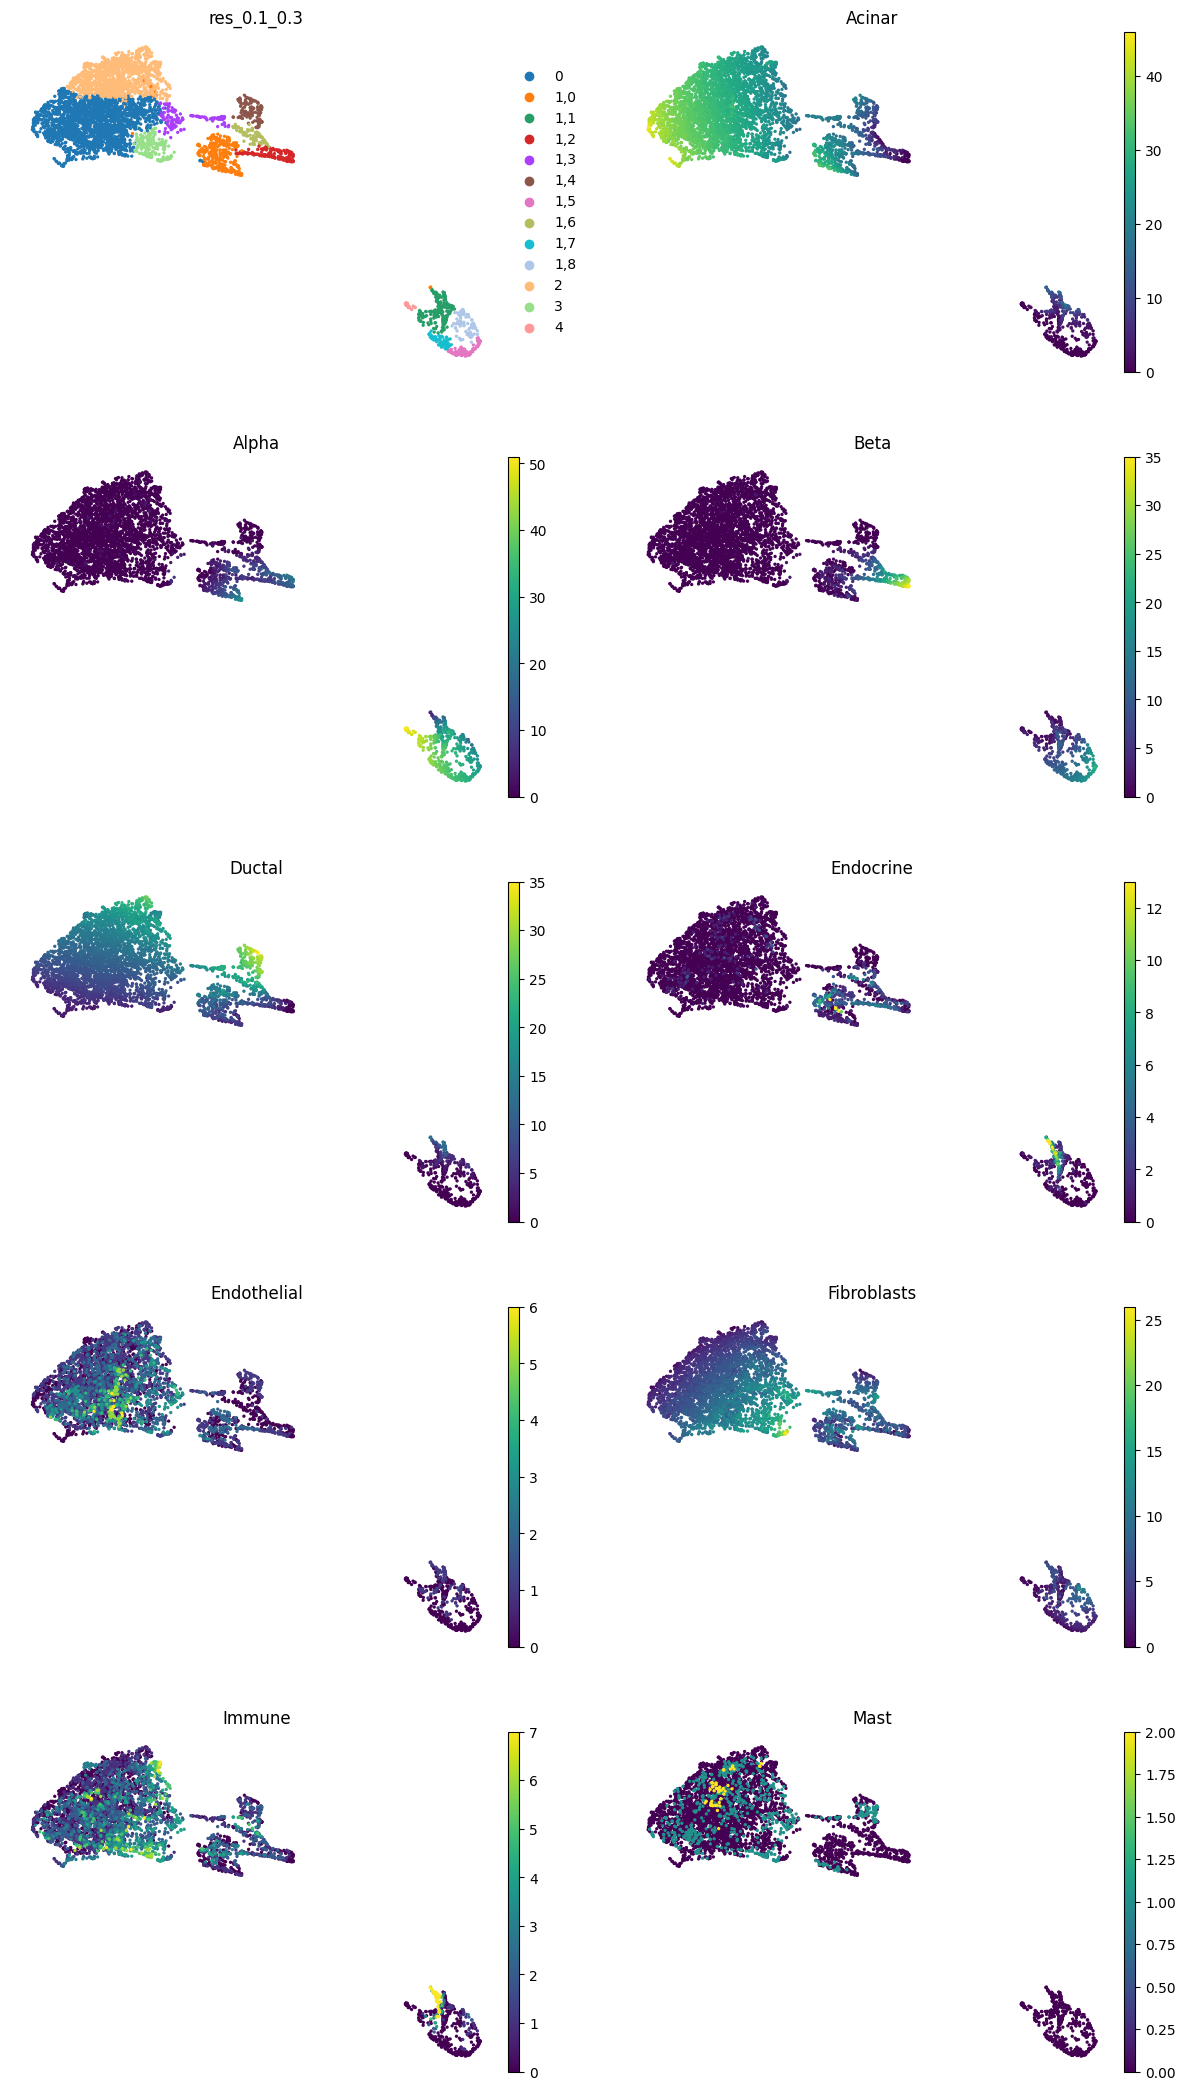

In [234]:
sc.pl.umap(niche_data, color=['res_0.1_0.3','Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],ncols=2, frameon=False)

In [235]:
niche_data.obs['res_0.1_0.3'].cat.categories

Index(['0', '1,0', '1,1', '1,2', '1,3', '1,4', '1,5', '1,6', '1,7', '1,8', '2',
       '3', '4'],
      dtype='object')

In [236]:
niche2annotation = {
    '0' : 'Acinar_enriched',
    '1,0' : 'Exocrine_Endocrine',
    '1,1' : 'Endocrine_Immune',
    '1,2' : 'Beta_enriched',
    '1,3' : 'Ductal_Fibroblasts',
    '1,4' : 'Ductal_enriched',
    '1,5' : 'Alpha_Beta',
    '1,6' : 'Ductal_enriched',
    '1,7' : 'Alpha_enriched',
    '1,8' : 'Alpha_Beta',
    '2' : 'Acinar_Ductal', 
    '3' : 'Support_cells',
    '4' : 'Alpha_enriched'
}

niche_data.obs['niche_label'] = niche_data.obs['res_0.1_0.3'].map(niche2annotation).astype('category')

niche_data.obs['niche_label'].cat.reorder_categories(['Acinar_enriched','Acinar_Ductal','Ductal_enriched','Ductal_Fibroblasts','Exocrine_Endocrine',
                                                      'Endocrine_Immune','Alpha_enriched','Beta_enriched','Alpha_Beta','Support_cells'])

1_12            Acinar_Ductal
2_12            Acinar_Ductal
3_12            Acinar_Ductal
4_12            Acinar_Ductal
5_12       Ductal_Fibroblasts
                  ...        
5224_12       Acinar_enriched
5225_12       Acinar_enriched
5226_12       Acinar_enriched
5227_12       Acinar_enriched
5228_12       Acinar_enriched
Name: niche_label, Length: 5208, dtype: category
Categories (10, object): ['Acinar_enriched', 'Acinar_Ductal', 'Ductal_enriched', 'Ductal_Fibroblasts', ..., 'Alpha_enriched', 'Beta_enriched', 'Alpha_Beta', 'Support_cells']

In [237]:
sc.tl.rank_genes_groups(niche_data, 'niche_label', method='t-test')

/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/aih/sara.jimenez/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the W

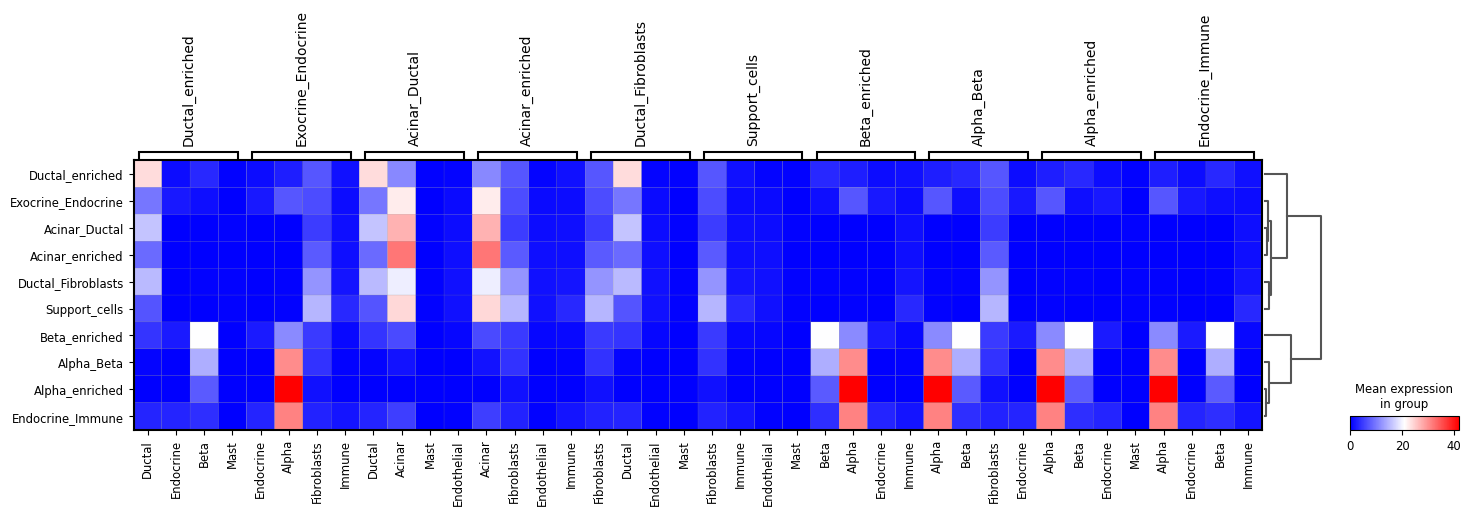

In [239]:
sc.tl.dendrogram(niche_data, groupby='niche_label')
sc.pl.rank_genes_groups_matrixplot(
    niche_data,
    n_genes=4,
    #values_to_plot="logfoldchanges",
    cmap='bwr',
)

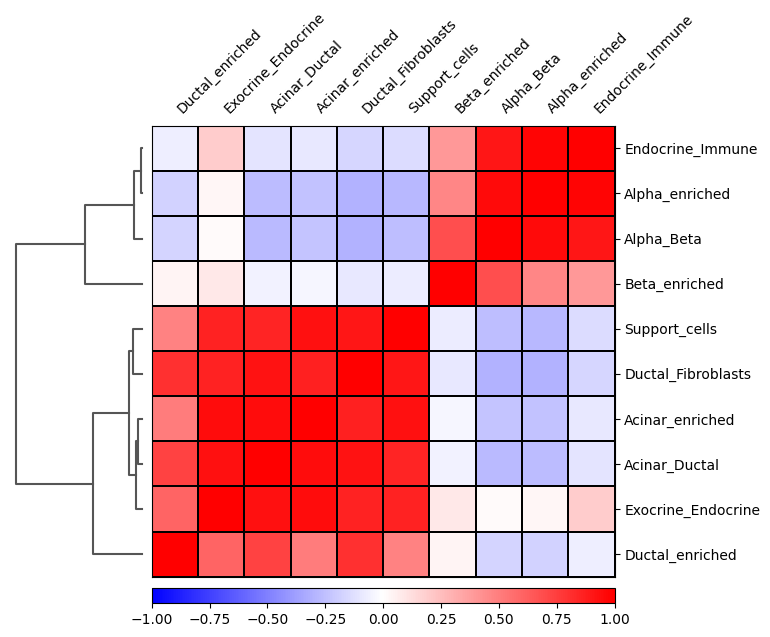

In [240]:
sc.pl.correlation_matrix(niche_data, "niche_label")

### Niche analysis

In [241]:
fov.obs['niche_label'] = niche_data.obs['niche_label']

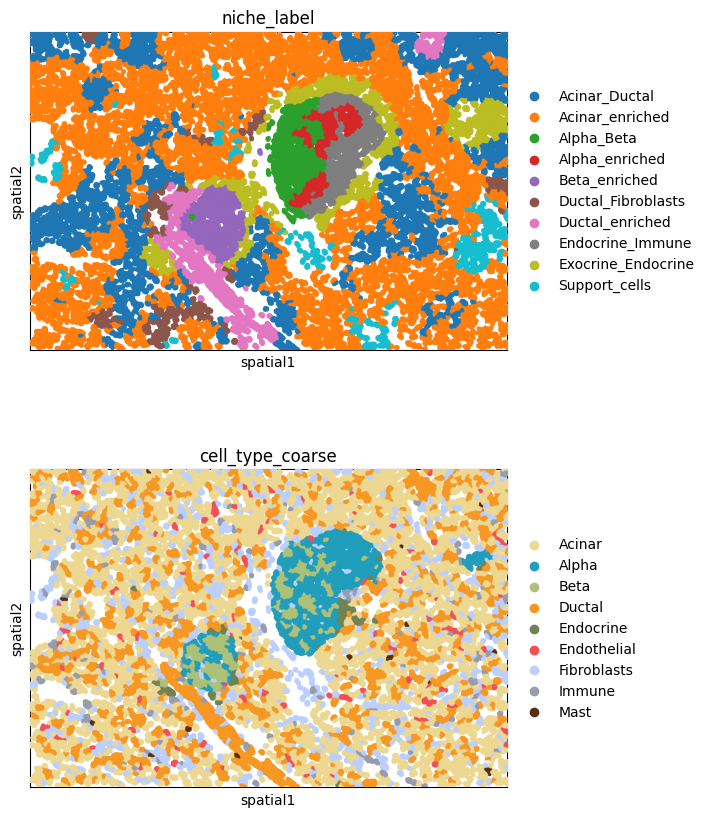

In [243]:
sq.pl.spatial_segment(
    fov,
    library_id="12",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=['niche_label','cell_type_coarse'],
    size=60,
    img=False,cmap="RdYlBu_r",ncols=1
)